In [1]:
from unsloth import FastLanguageModel
from unsloth import UnslothTrainer, UnslothTrainingArguments
from trl import SFTTrainer, SFTConfig
import torch

SEED = 42

/home/miguel/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
INFO 11-05 16:01:40 [__init__.py:216] Automatically detected platform cuda.
WARNING 11-05 16:01:40 [interface.py:391] Using 'pin_memory=False' as WSL is detected. This may slow down the performance.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [31]:
model_name = "meta-llama/Llama-3.2-1B-instruct"
MAX_LENGTH = 256

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = model_name,
    max_seq_length = MAX_LENGTH,
    full_finetuning=False,
    load_in_4bit = False,
    load_in_8bit = False,
)
if tokenizer.pad_token_id is None:
    tokenizer.pad_token = tokenizer.eos_token
    model.config.pad_token_id = tokenizer.eos_token_id
RANK = 512
model = FastLanguageModel.get_peft_model(
    model,
    r = RANK,           # Choose any number > 0! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = RANK*2,  # Best to choose alpha = rank or rank*2
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = SEED,
    use_rslora = False,   # We support rank stabilized LoRA
    loftq_config = None,  # And LoftQ
)

==((====))==  Unsloth 2025.9.8: Fast Llama patching. Transformers: 4.56.2. vLLM: 0.10.2.
   \\   /|    NVIDIA GeForce RTX 4090. Num GPUs = 1. Max memory: 23.988 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu128. CUDA: 8.9. CUDA Toolkit: 12.8. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


## Datasets

### tel

In [ ]:
from datasets import load_from_disk

dataset_qa = load_from_disk("../notebooks/data/dataset_instruct_train/")
# create validation dataset from dataset_qa
dataset_qa = dataset_qa.train_test_split(test_size=0.1, seed=SEED)
dataset_knowledge = load_from_disk("../notebooks/data/dataset_telephones")

documents = list(dataset_knowledge["text"])

### Simple dataset loading example

In [3]:
import pandas as pd
from langchain.schema import Document
dataset_knowledge = pd.read_csv("../notebooks/data/contacts_docs.csv")
documents = []
for index, row in dataset_knowledge.iterrows():
    doc = f"Nombre: {row['name']}\nTeléfono: {row['phone']}"
    documents.append(Document(page_content=doc, metadata={"id": f"{row['id']}" } ))
print(f"Loaded {len(documents)} documents.")
print(f"First document: {documents[0]}")


Loaded 400 documents.
First document: page_content='Nombre: Alba Alonso
Teléfono: 632 322 183' metadata={'id': '7500_1'}


In [4]:
query_dataset_train = pd.read_csv("../notebooks/data/contacts_queries_train.csv")
query_dataset_val = pd.read_csv("../notebooks/data/contacts_queries_val.csv")
query_dataset_test = pd.read_csv("../notebooks/data/contacts_queries_test.csv")


In [5]:
all_data = {
    "train": query_dataset_train,
    "validation": query_dataset_val,
    "test": query_dataset_test,
}

#to hugginface dataset
from datasets import Dataset, DatasetDict
dataset_qa = {}
for split in all_data:
    dataset_qa[split] = Dataset.from_pandas(all_data[split])
dataset_qa = DatasetDict(dataset_qa)

In [6]:
dataset_qa

DatasetDict({
    train: Dataset({
        features: ['question', 'id', 'respuesta'],
        num_rows: 1400
    })
    validation: Dataset({
        features: ['question', 'id', 'respuesta'],
        num_rows: 300
    })
    test: Dataset({
        features: ['question', 'id', 'respuesta'],
        num_rows: 300
    })
})

In [7]:
# JOIN TRAIN AND VAL DATASETS
from datasets import concatenate_datasets
dataset_qa["train"] = concatenate_datasets([dataset_qa["train"], dataset_qa["validation"]])

In [8]:
# rename "respuesta" column to "answer"
dataset_qa = dataset_qa.rename_column("respuesta", "answer")

In [9]:
dataset_qa

DatasetDict({
    train: Dataset({
        features: ['question', 'id', 'answer'],
        num_rows: 1700
    })
    validation: Dataset({
        features: ['question', 'id', 'answer'],
        num_rows: 300
    })
    test: Dataset({
        features: ['question', 'id', 'answer'],
        num_rows: 300
    })
})

### Data preparation

In [10]:
def build_prompt_it(tokenizer, system_prompt: str, prompt: str, response: str) -> str:
    """Builds the chat prompt for a single example using the tokenizer chat template."""
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user",   "content": prompt},
        {"role": "assistant", "content": response}
    ]
    return tokenizer.apply_chat_template(
        messages,
        tokenize=False,
    )

In [11]:
def generate_knowledge_injection_prompts(documents: list):
    prompt = """{doc}"""
    for doc in documents:
        yield prompt.format(doc=doc.page_content)

In [12]:
def generate_qa_prompts(dataset, tokenizer):
    system_prompt = """
    Eres un modelo de lenguaje entrenado para responder preguntas.
    """
    prompts = []
    for item in dataset:
        prompt = """{QUERY}"""
        response = "{response}"
        question = item["question"]
        prompt = prompt.format(QUERY=question)
        prompts.append(build_prompt_it(tokenizer, system_prompt, prompt, response.format(response=item["answer"])))
    return prompts

In [13]:
prompts = list(generate_knowledge_injection_prompts(documents))
print(f"Number of prompts: {len(prompts)}")

Number of prompts: 400


In [14]:
prompts[0]

'Nombre: Alba Alonso\nTeléfono: 632 322 183'

In [15]:
# QUIERO VER LOS TOKENS
def print_tokens(text):
    tokens = tokenizer.tokenize(text)
    print("Number of tokens:", len(tokens), "\n")
    print("Tokens:", tokens)

print_tokens(prompts[0])

Number of tokens: 15 

Tokens: ['Nombre', ':', 'ĠAl', 'ba', 'ĠAlonso', 'Ċ', 'Tel', 'Ã©fono', ':', 'Ġ', '632', 'Ġ', '322', 'Ġ', '183']


In [16]:
# create dataset from prompts
from datasets import Dataset
knowledge_dataset = Dataset.from_dict({"text": prompts})
knowledge_dataset

Dataset({
    features: ['text'],
    num_rows: 400
})

In [17]:
knowledge_dataset["text"][0]

'Nombre: Alba Alonso\nTeléfono: 632 322 183'

In [18]:
prompts_qa_train = generate_qa_prompts(dataset_qa["train"], tokenizer)
prompts_qa_val = generate_qa_prompts(dataset_qa["test"], tokenizer)

print(f"Number of retrieval prompts: {len(prompts_qa_train)}")
print(f"Number of retrieval prompts: {len(prompts_qa_val)}")

Number of retrieval prompts: 1700
Number of retrieval prompts: 300


In [19]:
print(prompts_qa_train[0], sep="\n")

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 05 Nov 2025

Eres un modelo de lenguaje entrenado para responder preguntas.<|eot_id|><|start_header_id|>user<|end_header_id|>

Necesito el contacto asociado al 620 152 344. —consulta interna—<|eot_id|><|start_header_id|>assistant<|end_header_id|>

El número 620 152 344 pertenece a Alejandro Vega.<|eot_id|>


In [20]:
print_tokens(prompts_qa_train[0])

Number of tokens: 87 

Tokens: ['<|begin_of_text|>', '<|start_header_id|>', 'system', '<|end_header_id|>', 'ĊĊ', 'Cut', 'ting', 'ĠKnowledge', 'ĠDate', ':', 'ĠDecember', 'Ġ', '202', '3', 'Ċ', 'Today', 'ĠDate', ':', 'Ġ', '05', 'ĠNov', 'Ġ', '202', '5', 'ĊĊ', 'E', 'res', 'Ġun', 'Ġmodelo', 'Ġde', 'Ġl', 'engu', 'aje', 'Ġentren', 'ado', 'Ġpara', 'Ġresponder', 'Ġpreg', 'untas', '.', '<|eot_id|>', '<|start_header_id|>', 'user', '<|end_header_id|>', 'ĊĊ', 'N', 'ec', 'es', 'ito', 'Ġel', 'Ġcontacto', 'Ġasoci', 'ado', 'Ġal', 'Ġ', '620', 'Ġ', '152', 'Ġ', '344', '.', 'ĠâĢĶ', 'consulta', 'Ġintern', 'a', 'âĢĶ', '<|eot_id|>', '<|start_header_id|>', 'assistant', '<|end_header_id|>', 'ĊĊ', 'El', 'ĠnÃºmero', 'Ġ', '620', 'Ġ', '152', 'Ġ', '344', 'Ġpert', 'ene', 'ce', 'Ġa', 'ĠAlejandro', 'ĠVega', '.', '<|eot_id|>']


In [21]:
# create dataset from prompts train, val, test
qa_train_dataset = Dataset.from_dict({"text": prompts_qa_train})
qa_val_dataset = Dataset.from_dict({"text": prompts_qa_val})

qa_dataset = {
    "train": qa_train_dataset,
    "validation": qa_val_dataset,
}

In [22]:
def tokenize_function_autoregressive(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=MAX_LENGTH)

In [23]:
knowledge_dataset_tokenizer = knowledge_dataset.map(tokenize_function_autoregressive, batched=True)

Map: 100%|██████████| 400/400 [00:00<00:00, 14645.94 examples/s]


In [24]:
qa_train_dataset_tokenizer = qa_dataset["train"].map(tokenize_function_autoregressive, batched=True)
qa_val_dataset_tokenizer = qa_dataset["validation"].map(tokenize_function_autoregressive, batched=True)

Map: 100%|██████████| 300/300 [00:00<00:00, 16041.04 examples/s]


In [25]:
def generate_qa_prompts_testing(dataset, tokenizer):
    def build_prompt_it_generation(tokenizer, system_prompt: str, prompt: str) -> str:
        """Builds the chat prompt for a single example using the tokenizer chat template."""
        messages = [
            {"role": "system", "content": system_prompt},
            {"role": "user",   "content": prompt},
        ]
        return tokenizer.apply_chat_template(
            messages,
            add_generation_prompt=True,
            tokenize=False,
        )
    system_prompt = """
    Eres un modelo de lenguaje entrenado para responder preguntas.
    """
    prompts = []
    for item in dataset:
        prompt = """{QUERY}"""
        question = item["question"]
        answer = item["answer"]
        prompt = prompt.format(QUERY=question)
        prompts.append(
            (
                build_prompt_it_generation(tokenizer, system_prompt, prompt),
                answer,
            )
        )
    return prompts

In [26]:
prompts_retrieval_test = generate_qa_prompts_testing(dataset_qa["test"], tokenizer)
text_for_testing = prompts_retrieval_test[0][0]
print(text_for_testing)

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 05 Nov 2025

Eres un modelo de lenguaje entrenado para responder preguntas.<|eot_id|><|start_header_id|>user<|end_header_id|>

¿A quién pertenece el teléfono 736 615 948?<|eot_id|><|start_header_id|>assistant<|end_header_id|>




In [27]:
import re
import tqdm
import torch

def test_model_accuracy(model, tokenizer, prompts_retrieval_test, device="cuda", 
                        max_new_tokens=64, temperature=0.0, top_p=1.0):
    
    acc = 0
    total = 0

    progress_bar = tqdm.tqdm(prompts_retrieval_test, desc="Testing")

    for text, answer in progress_bar:
        inputs = tokenizer(text, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=max_new_tokens,
                do_sample=False,
                temperature=temperature,
                top_p=top_p
            )
        generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        response = generated_text.split("assistant")[-1].strip()

        if response == answer:
            acc += 1
        total += 1

        progress_bar.set_postfix({
            "acc": f"{acc/total*100:.2f} %"
        })

    final_acc = acc / total * 100 if total > 0 else 0.0
    print(f"Accuracy final: {acc}/{total} = {final_acc:.2f} %")
    return final_acc

In [28]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Genera gráficos de la evolución de la accuracy y las pérdidas (SFT e IT) durante el entrenamiento.

    Parámetros:
        history (list[dict]): lista de diccionarios, donde cada elemento debe contener:
            - "super_epoch": número de super-época.
            - "accuracy": precisión alcanzada.
            - "trainer_sft_stats".training_loss: pérdida SFT.
            - "trainer_it_stats".training_loss: pérdida IT.
    """
    # Extraer métricas del historial
    super_epochs = [h["super_epoch"] for h in history]
    accuracies = [h["accuracy"] for h in history]
    losses_sft = [h["trainer_sft_stats"].training_loss for h in history]
    losses_it = [h["trainer_it_stats"].training_loss for h in history]

    # --- Gráfico de Accuracy ---
    plt.figure(figsize=(6, 4))
    plt.plot(super_epochs, accuracies, marker='o', color='tab:blue')
    plt.xlabel("Super Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Accuracy History")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Gráfico de Losses ---
    plt.figure(figsize=(6, 4))
    plt.plot(super_epochs, losses_sft, marker='o', label="SFT Loss", color='tab:orange')
    plt.plot(super_epochs, losses_it, marker='s', label="IT Loss", color='tab:green')
    plt.xlabel("Super Epoch")
    plt.ylabel("Loss")
    plt.title("Loss History")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## Train

### Iterative training configuration

In [29]:
# sft training
from transformers import DataCollatorForLanguageModeling


data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)
auto_config = UnslothTrainingArguments(
    per_device_train_batch_size = 8,
    gradient_accumulation_steps = 8, # Use GA to mimic batch size!
    save_strategy="no",
    save_total_limit=0,
    warmup_steps = 5,
    num_train_epochs = 1, # Set this for 1 full training run.
    #max_steps = 60,
    learning_rate = 1e-4, # Reduce to 2e-5 for long training runs
    logging_steps = 1,
    # 32 bits
    optim = "paged_adamw_32bit",
    weight_decay = 0.01,
    lr_scheduler_type = "cosine",
    seed = SEED,
    report_to = "none", # Use this for WandB etc
    output_dir="../models/qwen3-0.6b-rag-indexer",
)

it_config = SFTConfig(
    dataset_text_field="text",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,        # <-- añade eval batch size
    gradient_accumulation_steps=8,
    warmup_steps=25,
    save_strategy="no",
    save_total_limit=0,
    eval_steps=1,
    eval_strategy="steps",         # <-- activa evaluación periódica
    num_train_epochs=1,             # <-- opcional: usa epochs en lugar de max_steps
    #max_steps=30,
    learning_rate=1e-4,
    logging_steps=1,
    optim = "paged_adamw_32bit",
    weight_decay=0.01,
    lr_scheduler_type="cosine",
    seed=SEED,
    report_to="none",
    output_dir="../models/qwen3-0.6b-rag-retriever",
    load_best_model_at_end=False,          # <-- opcional
    metric_for_best_model="eval_loss",    # <-- opcional
    greater_is_better=False,              # <-- opcional
)

trainer_auto = UnslothTrainer(
    model=model,
    train_dataset=knowledge_dataset_tokenizer,
    tokenizer=tokenizer,
    data_collator=data_collator,
    args=auto_config,
)

trainer_it = SFTTrainer(
    model=model,
    train_dataset=qa_train_dataset_tokenizer,
    eval_dataset=qa_val_dataset_tokenizer,
    data_collator=data_collator,
    tokenizer=tokenizer,
    args=it_config,
)

In [31]:
model.print_trainable_parameters()

trainable params: 360,710,144 || all params: 1,596,524,544 || trainable%: 22.5935


In [32]:
EPOCHS = 10
history = []
for _ in range(EPOCHS):
    print(f"--- SUPER EPOCH {_+1} / {EPOCHS} ---")
    trainer_sft_stats = trainer_auto.train() 
    trainer_it_stats = trainer_it.train()
    # evaluate accuracy after each super epoch
    acc = test_model_accuracy(model, tokenizer, prompts_retrieval_test, device="cuda")
    print(f"Accuracy: {acc:.2f} %")
    history.append({
        "super_epoch": _ + 1,
        "trainer_sft_stats": trainer_sft_stats,
        "trainer_it_stats": trainer_it_stats,
        "accuracy": acc,
    })

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 400 | Num Epochs = 1 | Total steps = 7
O^O/ \_/ \    Batch size per device = 8 | Gradient accumulation steps = 8
\        /    Data Parallel GPUs = 1 | Total batch size (8 x 8 x 1) = 64
 "-____-"     Trainable parameters = 360,710,144 of 1,596,524,544 (22.59% trained)


--- SUPER EPOCH 1 / 10 ---
Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,4.325900
2,4.296200
3,3.141900
4,2.794800
5,2.250100
6,1.886700
7,1.923700


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,700 | Num Epochs = 1 | Total steps = 27
O^O/ \_/ \    Batch size per device = 8 | Gradient accumulation steps = 8
\        /    Data Parallel GPUs = 1 | Total batch size (8 x 8 x 1) = 64
 "-____-"     Trainable parameters = 360,710,144 of 1,596,524,544 (22.59% trained)


Step,Training Loss,Validation Loss
1,5.435800,5.437668
2,5.384600,4.394589
3,4.390800,3.340816
4,3.300200,2.516832
5,2.496800,1.952396
6,1.947700,1.422426
7,1.387500,1.111317
8,1.100200,0.878597
9,0.908800,0.770820
10,0.794300,0.719856


Unsloth: Not an error, but LlamaForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient
Testing: 100%|██████████| 300/300 [01:25<00:00,  3.53it/s, acc=0.00 %]


Accuracy final: 0/300 = 0.00 %
Accuracy: 0.00 %
--- SUPER EPOCH 2 / 10 ---


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 400 | Num Epochs = 1 | Total steps = 7
O^O/ \_/ \    Batch size per device = 8 | Gradient accumulation steps = 8
\        /    Data Parallel GPUs = 1 | Total batch size (8 x 8 x 1) = 64
 "-____-"     Trainable parameters = 360,710,144 of 1,596,524,544 (22.59% trained)


Step,Training Loss
1,2.585500
2,2.560600
3,2.285100
4,2.159200
5,2.026900
6,1.882500
7,1.662200


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,700 | Num Epochs = 1 | Total steps = 27
O^O/ \_/ \    Batch size per device = 8 | Gradient accumulation steps = 8
\        /    Data Parallel GPUs = 1 | Total batch size (8 x 8 x 1) = 64
 "-____-"     Trainable parameters = 360,710,144 of 1,596,524,544 (22.59% trained)


Step,Training Loss,Validation Loss
1,0.839800,0.836634
2,0.835200,0.771902
3,0.777300,0.631360
4,0.623300,0.533320
5,0.528000,0.511222
6,0.511000,0.495143
7,0.495400,0.475509
8,0.475000,0.499686
9,0.497600,0.455014
10,0.462400,0.443395


Testing: 100%|██████████| 300/300 [01:29<00:00,  3.35it/s, acc=0.00 %]


Accuracy final: 0/300 = 0.00 %
Accuracy: 0.00 %
--- SUPER EPOCH 3 / 10 ---


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 400 | Num Epochs = 1 | Total steps = 7
O^O/ \_/ \    Batch size per device = 8 | Gradient accumulation steps = 8
\        /    Data Parallel GPUs = 1 | Total batch size (8 x 8 x 1) = 64
 "-____-"     Trainable parameters = 360,710,144 of 1,596,524,544 (22.59% trained)


Step,Training Loss
1,2.912300
2,2.897300
3,2.738000
4,2.558900
5,2.338700
6,2.089800
7,1.598600


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,700 | Num Epochs = 1 | Total steps = 27
O^O/ \_/ \    Batch size per device = 8 | Gradient accumulation steps = 8
\        /    Data Parallel GPUs = 1 | Total batch size (8 x 8 x 1) = 64
 "-____-"     Trainable parameters = 360,710,144 of 1,596,524,544 (22.59% trained)


Step,Training Loss,Validation Loss
1,0.399400,0.399000
2,0.400600,0.392303
3,0.393600,0.388491
4,0.386500,0.384447
5,0.384000,0.379683
6,0.387300,0.374142
7,0.372500,0.370768
8,0.364100,0.366695
9,0.374900,0.360301
10,0.372300,0.354022


Testing: 100%|██████████| 300/300 [01:28<00:00,  3.40it/s, acc=0.00 %]


Accuracy final: 0/300 = 0.00 %
Accuracy: 0.00 %
--- SUPER EPOCH 4 / 10 ---


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 400 | Num Epochs = 1 | Total steps = 7
O^O/ \_/ \    Batch size per device = 8 | Gradient accumulation steps = 8
\        /    Data Parallel GPUs = 1 | Total batch size (8 x 8 x 1) = 64
 "-____-"     Trainable parameters = 360,710,144 of 1,596,524,544 (22.59% trained)


Step,Training Loss
1,2.111300
2,2.108500
3,1.955700
4,1.754800
5,1.465700
6,1.149000
7,0.753600


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,700 | Num Epochs = 1 | Total steps = 27
O^O/ \_/ \    Batch size per device = 8 | Gradient accumulation steps = 8
\        /    Data Parallel GPUs = 1 | Total batch size (8 x 8 x 1) = 64
 "-____-"     Trainable parameters = 360,710,144 of 1,596,524,544 (22.59% trained)


Step,Training Loss,Validation Loss
1,0.326400,0.334522
2,0.328100,0.333232
3,0.329100,0.324542
4,0.315200,0.312048
5,0.305300,0.292770
6,0.283700,0.272556
7,0.268200,0.254531
8,0.245700,0.242147
9,0.234800,0.236689
10,0.229700,0.235259


Testing: 100%|██████████| 300/300 [01:22<00:00,  3.65it/s, acc=0.33 %]


Accuracy final: 1/300 = 0.33 %
Accuracy: 0.33 %
--- SUPER EPOCH 5 / 10 ---


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 400 | Num Epochs = 1 | Total steps = 7
O^O/ \_/ \    Batch size per device = 8 | Gradient accumulation steps = 8
\        /    Data Parallel GPUs = 1 | Total batch size (8 x 8 x 1) = 64
 "-____-"     Trainable parameters = 360,710,144 of 1,596,524,544 (22.59% trained)


Step,Training Loss
1,2.249400
2,2.255200
3,2.161800
4,2.005000
5,1.859800
6,1.640800
7,1.214000


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,700 | Num Epochs = 1 | Total steps = 27
O^O/ \_/ \    Batch size per device = 8 | Gradient accumulation steps = 8
\        /    Data Parallel GPUs = 1 | Total batch size (8 x 8 x 1) = 64
 "-____-"     Trainable parameters = 360,710,144 of 1,596,524,544 (22.59% trained)


Step,Training Loss,Validation Loss
1,1.159300,1.164124
2,1.161900,0.990628
3,0.988500,0.858539
4,0.853600,0.653342
5,0.645800,0.259646
6,0.250100,0.322773
7,0.321300,0.231389
8,0.219400,0.229344
9,0.221500,0.226438
10,0.226700,0.223157


Testing: 100%|██████████| 300/300 [01:29<00:00,  3.35it/s, acc=9.00 %] 


Accuracy final: 27/300 = 9.00 %
Accuracy: 9.00 %
--- SUPER EPOCH 6 / 10 ---


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 400 | Num Epochs = 1 | Total steps = 7
O^O/ \_/ \    Batch size per device = 8 | Gradient accumulation steps = 8
\        /    Data Parallel GPUs = 1 | Total batch size (8 x 8 x 1) = 64
 "-____-"     Trainable parameters = 360,710,144 of 1,596,524,544 (22.59% trained)


Step,Training Loss
1,1.593700
2,1.590200
3,1.480600
4,1.370200
5,1.228800
6,1.072700
7,0.719600


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,700 | Num Epochs = 1 | Total steps = 27
O^O/ \_/ \    Batch size per device = 8 | Gradient accumulation steps = 8
\        /    Data Parallel GPUs = 1 | Total batch size (8 x 8 x 1) = 64
 "-____-"     Trainable parameters = 360,710,144 of 1,596,524,544 (22.59% trained)


Step,Training Loss,Validation Loss
1,0.203000,0.208649
2,0.210600,0.208091
3,0.203700,0.205885
4,0.208300,0.202976
5,0.199900,0.200300
6,0.194100,0.197545
7,0.194600,0.195678
8,0.181300,0.194681
9,0.181200,0.194439
10,0.176900,0.194293


Testing: 100%|██████████| 300/300 [01:24<00:00,  3.55it/s, acc=40.67 %]


Accuracy final: 122/300 = 40.67 %
Accuracy: 40.67 %
--- SUPER EPOCH 7 / 10 ---


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 400 | Num Epochs = 1 | Total steps = 7
O^O/ \_/ \    Batch size per device = 8 | Gradient accumulation steps = 8
\        /    Data Parallel GPUs = 1 | Total batch size (8 x 8 x 1) = 64
 "-____-"     Trainable parameters = 360,710,144 of 1,596,524,544 (22.59% trained)


Step,Training Loss
1,1.062200
2,1.049900
3,0.946000
4,0.834400
5,0.690900
6,0.534900
7,0.370500


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,700 | Num Epochs = 1 | Total steps = 27
O^O/ \_/ \    Batch size per device = 8 | Gradient accumulation steps = 8
\        /    Data Parallel GPUs = 1 | Total batch size (8 x 8 x 1) = 64
 "-____-"     Trainable parameters = 360,710,144 of 1,596,524,544 (22.59% trained)


Step,Training Loss,Validation Loss
1,0.258200,0.265003
2,0.263400,0.262318
3,0.252100,0.256653
4,0.254600,0.248134
5,0.243500,0.235111
6,0.224900,0.218459
7,0.213800,0.199103
8,0.186600,0.182381
9,0.167600,0.172755
10,0.157100,0.168893


Testing: 100%|██████████| 300/300 [01:22<00:00,  3.62it/s, acc=66.67 %]


Accuracy final: 200/300 = 66.67 %
Accuracy: 66.67 %
--- SUPER EPOCH 8 / 10 ---


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 400 | Num Epochs = 1 | Total steps = 7
O^O/ \_/ \    Batch size per device = 8 | Gradient accumulation steps = 8
\        /    Data Parallel GPUs = 1 | Total batch size (8 x 8 x 1) = 64
 "-____-"     Trainable parameters = 360,710,144 of 1,596,524,544 (22.59% trained)


Step,Training Loss
1,1.705900
2,1.720300
3,1.634900
4,1.544700
5,1.435100
6,1.318400
7,0.957500


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,700 | Num Epochs = 1 | Total steps = 27
O^O/ \_/ \    Batch size per device = 8 | Gradient accumulation steps = 8
\        /    Data Parallel GPUs = 1 | Total batch size (8 x 8 x 1) = 64
 "-____-"     Trainable parameters = 360,710,144 of 1,596,524,544 (22.59% trained)


Step,Training Loss,Validation Loss
1,0.158300,0.170154
2,0.157400,0.169216
3,0.156700,0.167744
4,0.159000,0.165450
5,0.151400,0.162624
6,0.145100,0.160546
7,0.148800,0.159795
8,0.145800,0.159989
9,0.144600,0.160841
10,0.146400,0.161739


Testing: 100%|██████████| 300/300 [01:32<00:00,  3.24it/s, acc=82.00 %]


Accuracy final: 246/300 = 82.00 %
Accuracy: 82.00 %
--- SUPER EPOCH 9 / 10 ---


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 400 | Num Epochs = 1 | Total steps = 7
O^O/ \_/ \    Batch size per device = 8 | Gradient accumulation steps = 8
\        /    Data Parallel GPUs = 1 | Total batch size (8 x 8 x 1) = 64
 "-____-"     Trainable parameters = 360,710,144 of 1,596,524,544 (22.59% trained)


Step,Training Loss
1,1.251300
2,1.256900
3,1.192800
4,1.108900
5,1.001000
6,0.860100
7,0.642300


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,700 | Num Epochs = 1 | Total steps = 27
O^O/ \_/ \    Batch size per device = 8 | Gradient accumulation steps = 8
\        /    Data Parallel GPUs = 1 | Total batch size (8 x 8 x 1) = 64
 "-____-"     Trainable parameters = 360,710,144 of 1,596,524,544 (22.59% trained)


Step,Training Loss,Validation Loss
1,0.153400,0.165824
2,0.151400,0.165271
3,0.152000,0.164071
4,0.150500,0.162959
5,0.146600,0.161030
6,0.140800,0.159649
7,0.144400,0.158398
8,0.141000,0.157365
9,0.141600,0.157463
10,0.142500,0.158401


Testing: 100%|██████████| 300/300 [01:24<00:00,  3.56it/s, acc=93.33 %]


Accuracy final: 280/300 = 93.33 %
Accuracy: 93.33 %
--- SUPER EPOCH 10 / 10 ---


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 400 | Num Epochs = 1 | Total steps = 7
O^O/ \_/ \    Batch size per device = 8 | Gradient accumulation steps = 8
\        /    Data Parallel GPUs = 1 | Total batch size (8 x 8 x 1) = 64
 "-____-"     Trainable parameters = 360,710,144 of 1,596,524,544 (22.59% trained)


Step,Training Loss
1,0.843200
2,0.848600
3,0.785900
4,0.706100
5,0.590200
6,0.483700
7,0.336600


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,700 | Num Epochs = 1 | Total steps = 27
O^O/ \_/ \    Batch size per device = 8 | Gradient accumulation steps = 8
\        /    Data Parallel GPUs = 1 | Total batch size (8 x 8 x 1) = 64
 "-____-"     Trainable parameters = 360,710,144 of 1,596,524,544 (22.59% trained)


Step,Training Loss,Validation Loss
1,0.241100,0.257830
2,0.236000,0.254716
3,0.235300,0.252796
4,0.232700,0.245491
5,0.223300,0.233649
6,0.209400,0.218519
7,0.200800,0.200358
8,0.180400,0.182717
9,0.163600,0.167625
10,0.148500,0.159801


Testing: 100%|██████████| 300/300 [01:22<00:00,  3.64it/s, acc=94.67 %]

Accuracy final: 284/300 = 94.67 %
Accuracy: 94.67 %


In [33]:
# test the model in streaming mode
from transformers import TextStreamer

streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=False)
_ = model.generate(
    **tokenizer(text_for_testing, return_tensors = "pt").to("cuda"),
    max_new_tokens = 64, # Increase for longer outputs!
    do_sample = False,
    top_p = 0.1,
    temperature = 0.,
    streamer = streamer,
)

El número 736 615 948 pertenece a Javier Martín.<|eot_id|>


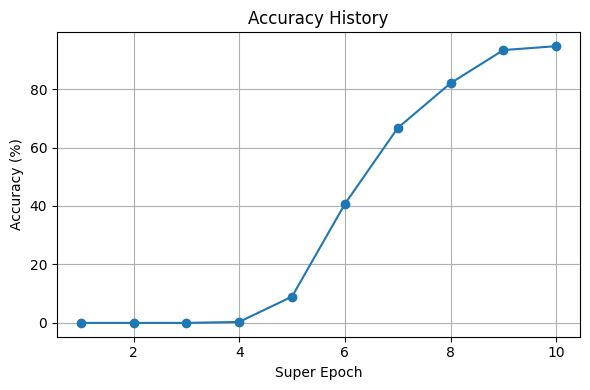

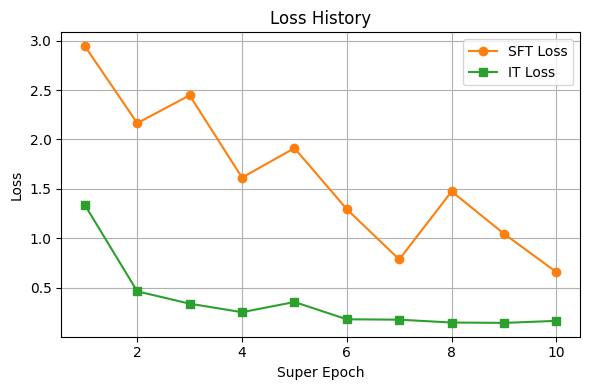

In [45]:
plot_training_history(history)

### Split training in super epochs

In [32]:
from transformers import DataCollatorForLanguageModeling


data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)
auto_config = UnslothTrainingArguments(
    per_device_train_batch_size = 8,
    gradient_accumulation_steps = 8, # Use GA to mimic batch size!
    save_strategy="no",
    save_total_limit=0,
    warmup_steps = 5,
    num_train_epochs = 10, # Set this for 1 full training run.
    #max_steps = 60,
    learning_rate = 1e-4, # Reduce to 2e-5 for long training runs
    logging_steps = 1,
    # 32 bits
    optim = "paged_adamw_32bit",
    weight_decay = 0.01,
    lr_scheduler_type = "cosine",
    seed = SEED,
    report_to = "none", # Use this for WandB etc
    output_dir="../models/qwen3-0.6b-rag-indexer",
)

it_config = SFTConfig(
    dataset_text_field="text",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,        # <-- añade eval batch size
    gradient_accumulation_steps=8,
    warmup_steps=25,
    save_strategy="no",
    save_total_limit=0,
    eval_steps=1,
    eval_strategy="steps",         # <-- activa evaluación periódica
    num_train_epochs=1,             # <-- opcional: usa epochs en lugar de max_steps
    #max_steps=30,
    learning_rate=1e-4,
    logging_steps=1,
    optim = "paged_adamw_32bit",
    weight_decay=0.01,
    lr_scheduler_type="cosine",
    seed=SEED,
    report_to="none",
    output_dir="../models/qwen3-0.6b-rag-retriever",
    load_best_model_at_end=False,          # <-- opcional
    metric_for_best_model="eval_loss",    # <-- opcional
    greater_is_better=False,              # <-- opcional
)

trainer_auto = UnslothTrainer(
    model=model,
    train_dataset=knowledge_dataset_tokenizer,
    tokenizer=tokenizer,
    data_collator=data_collator,
    args=auto_config,
)

trainer_it = SFTTrainer(
    model=model,
    train_dataset=qa_train_dataset_tokenizer,
    eval_dataset=qa_val_dataset_tokenizer,
    data_collator=data_collator,
    tokenizer=tokenizer,
    args=it_config,
)

In [33]:
trainer_sft_stats = trainer_auto.train()
trainer_it_stats = trainer_it.train()
# evaluate accuracy after each super epoch
acc = test_model_accuracy(model, tokenizer, prompts_retrieval_test, device="cuda")
print(f"Accuracy: {acc:.2f} %")


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 400 | Num Epochs = 10 | Total steps = 70
O^O/ \_/ \    Batch size per device = 8 | Gradient accumulation steps = 8
\        /    Data Parallel GPUs = 1 | Total batch size (8 x 8 x 1) = 64
 "-____-"     Trainable parameters = 360,710,144 of 1,596,524,544 (22.59% trained)


Step,Training Loss
1,4.325900
2,4.296200
3,3.141900
4,2.794800
5,2.250100
6,1.886700
7,1.923700
8,1.847300
9,1.863400
10,1.833400


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,700 | Num Epochs = 1 | Total steps = 27
O^O/ \_/ \    Batch size per device = 8 | Gradient accumulation steps = 8
\        /    Data Parallel GPUs = 1 | Total batch size (8 x 8 x 1) = 64
 "-____-"     Trainable parameters = 360,710,144 of 1,596,524,544 (22.59% trained)


Step,Training Loss,Validation Loss
1,6.801400,6.797376
2,6.749600,5.844672
3,5.854400,4.569393
4,4.548200,3.430390
5,3.376600,2.751632
6,2.735900,2.153765
7,2.113100,1.609959
8,1.585600,1.227074
9,1.253000,0.953801
10,0.982600,0.879649


Testing: 100%|██████████| 300/300 [01:25<00:00,  3.49it/s, acc=0.00 %]

Accuracy final: 0/300 = 0.00 %
Accuracy: 0.00 %


iterativo(Super epocas = 10) => auto_loss 0.33 || it_loss 0.17 || ACC 0.94

NORMAL => auto_loss 0.86 || it_loss 0.35 || ACC 0.